# Phase Diagram of a single Dimer

Here I generate the phase diagram of a single dimer. 

In [1]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp

%matplotlib inline
%reload_ext autoreload
%autoreload 2

I will start all particles from a configuration like this:
<img src=StartingConfig.png>

In [83]:
temp = 300 # K
Kb = 4/300 # pN nm / K
diffusion = 0.1e6 #nm^2/s
drag = Kb*temp/diffusion #pN/(nm/s)

def hi_level(height = 5, angle = 90, frequency = 10):
    sigma = 2.8
    
    x = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
    z = 1/2*(sigma-height)
    initial_positions = np.array([[-x,0,-z],[x,0,z]])

    sim = lmp.sim(initial_positions,
                  magnitude = 3,
                  radius = sigma/2,
                  drag = drag,
                  frequency=frequency,
                  susceptibility = 0.5,
                  angle=angle,
                  framerate=1e1,
                  timestep=1e-4,
                  total_time = 10,
                  space = {'region':[100,100,height],'boundary':['f','f','f'],'walls':[True,True,True]},
                  temperature = 300)
    sim.generate_scripts()
    sim.run()

    return sim

In [4]:
def is_dimer(sim):
    sim.load()
    sim.lazy_read
    last_frame = max(list(sim.lazy_read.T.keys()))
    frame = sim.lazy_read.readframe(last_frame)

    p1 = frame[frame['id']==1]
    p2 = frame[frame['id']==2]
    distance = np.sqrt((p1['x']-p2['x'])**2+(p1['y']-p2['y'])**2+(p1['z']-p2['z'])**2)
    if sim.run_steps == max(list(sim.lazy_read.T.keys())):
        return (distance-sim.particle_properties[0].radius*2)<1.2
    else:
        return np.array([])

# Phase Diagram

In [8]:
def DimerPhaseDiagram(N):
    ## Create Space
    alpha = np.linspace(0,85,N)
    height = 2.8*np.cos(alpha/180*np.pi)+2.8
    angle = np.linspace(0,90,N)

    [H,A] = np.meshgrid(height,angle)
    dimer_space_low = -1*np.ones(np.shape(H)).flatten()
    dimer_space_high = -1*np.ones(np.shape(H)).flatten()

    S = list(dimer_space_high);

    ## Map Space
    for i,(h,a) in enumerate(zip(H.flatten(),A.flatten())):
        S[i] = hi_level(height = h, angle = a,frequency=1)
        d = is_dimer(S[i])
        if d.size>0:
            dimer_space_low[i]=d

        S[i] = hi_level(height = h, angle = a,frequency=20)
        d = is_dimer(S[i])
        if d.size>0:
            dimer_space_high[i]=d
    ## Display        
    h = dimer_space_high
    l = dimer_space_low

    alpha = np.arccos((H.flatten()-2.8)/2.8)

    color = ['r' if (h==1) & (l==1) else
         'b' if (h==0) & (l==0) else
         'm' if (h==0) & (l==1) else
         'c' if (h==1) & (l==0) else
         'gray' for (h,l) in zip(dimer_space_high,dimer_space_low)]
    plt.scatter(alpha.flatten()/np.pi,A.flatten()/180,c=color)
    plt.xlabel('$\\alpha [\pi rad]$')
    plt.ylabel('angle $[\pi rad]$')

## $T=300K$

In [84]:
temp = 300 # K
Kb = 4/300 # pN nm / K
diffusion = 0.1e6 #nm^2/s
drag = Kb*temp/diffusion #pN/(nm/s)

def hi_level(height = 5, angle = 90, frequency = 10):
    sigma = 2.8
    
    x = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
    z = 1/2*(sigma-height)
    initial_positions = np.array([[-x,0,-z],[x,0,z]])

    sim = lmp.sim(initial_positions,
                  magnitude = 3,
                  radius = sigma/2,
                  drag = drag,
                  frequency=frequency,
                  susceptibility = 0.5,
                  angle=angle,
                  framerate=1e1,
                  timestep=1e-4,
                  total_time = 10,
                  space = {'region':[100,100,height],'boundary':['f','f','f'],'walls':[True,True,True]},
                  temperature = 300)
    sim.generate_scripts()
    sim.run()

    return sim

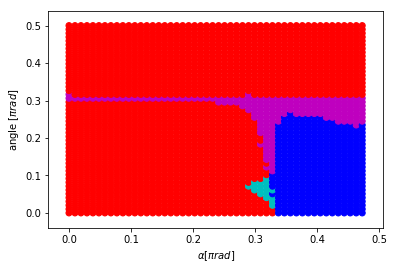

In [85]:
DimerPhaseDiagram(50)

## $T=1K$

In [86]:
temp = 300 # K
Kb = 4/300 # pN nm / K
diffusion = 0.1e6 #nm^2/s
drag = Kb*temp/diffusion #pN/(nm/s)

def hi_level(height = 5, angle = 90, frequency = 10):
    sigma = 2.8
    
    x = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
    z = 1/2*(sigma-height)
    initial_positions = np.array([[-x,0,-z],[x,0,z]])

    sim = lmp.sim(initial_positions,
                  magnitude = 3,
                  radius = sigma/2,
                  drag = drag,
                  frequency=frequency,
                  susceptibility = 0.5,
                  angle=angle,
                  framerate=1e1,
                  timestep=1e-4,
                  total_time = 10,
                  space = {'region':[100,100,height],'boundary':['f','f','f'],'walls':[True,True,True]},
                  temperature = 1)
    sim.generate_scripts()
    sim.run()

    return sim

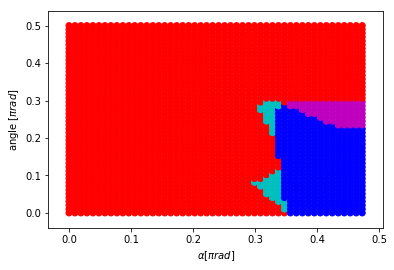

In [87]:
DimerPhaseDiagram(50)

# Support Functions

In [11]:
def plot_trj(trj):
    idx = pd.IndexSlice

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    for i in trj.index.get_level_values('id').unique():
        ax1.plot(trj.loc[idx[:,i],'x'],trj.loc[idx[:,i],'y'])
        ax2.plot(trj.loc[idx[:,i],'x'],trj.loc[idx[:,i],'z'])

    ax1.set(aspect='equal');
    ax1.set_xlabel('$x[\mu{m}]$')
    ax1.set_ylabel('$y[\mu{m}]$')
    ax2.set(aspect='equal');
    ax2.set_xlabel('$x[\mu{m}]$')
    ax2.set_ylabel('$z[\mu{m}]$')
    ax2.set_ylim([-5,5])

In [12]:
def plot_distance(trj, ax=None):
    idx = pd.IndexSlice
    if ax==None:
        fig, ax = plt.subplots(1,figsize=(15,5))
    
    ax.plot(trj.xs(1,level='id').t,
             np.sqrt((trj.loc[idx[:,1],'x'].values-trj.loc[idx[:,2],'x'].values)**2 + 
                    (trj.loc[idx[:,1],'y'].values-trj.loc[idx[:,2],'y'].values)**2 + 
                    (trj.loc[idx[:,1],'z'].values-trj.loc[idx[:,2],'z'].values)**2))
    ax.plot(trj.xs(1,level='id').t,trj.xs(1,level='id').index*0+2.8)
    ax.set_xlabel('$t[s]$')
    ax.set_ylabel('$d[\mu{m}]$')
    return ax